In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import ssl

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.7.1
Populating the interactive namespace from numpy and matplotlib


In [3]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('005930', 'naver', start, end) # yahoo 안불러와져서 예제와는 다르게 naver로 진행

In [5]:
google = google.apply(pd.to_numeric)
google = google[(google['Low']>1000)]

In [6]:
google

,Open,High,Low,Close,Volume
Date,,,,,
2000-12-01,3080,3220,3040,3180,1928557
2000-12-04,3220,3250,3080,3100,1037540
2000-12-05,3160,3250,3120,3240,1168095
2000-12-06,3410,3430,3210,3210,1917834
2000-12-07,3210,3260,3160,3260,860422
...,...,...,...,...,...
2022-02-03,74900,74900,73300,73300,17744721
2022-02-04,74300,74600,73400,74000,12730034
2022-02-07,73500,73600,72400,73000,14240838


<AxesSubplot:xlabel='Date'>

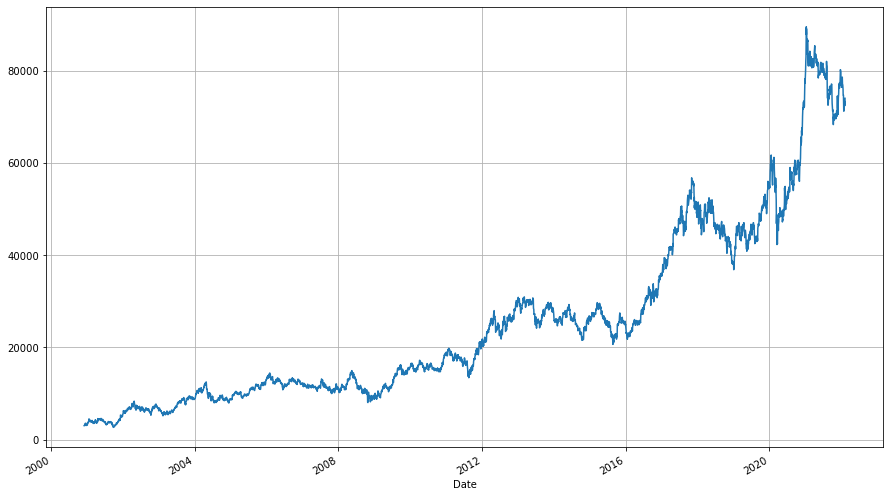

In [7]:
google.Low.plot(grid=True)

# Data Preparation

## 커스텀데이터셋 만들기
- Dataset: i번째 레코드 값을 주는 역할을 함 
 : 데이터 요청을 받으면 데이터를 꺼내줌
- DataLoader: 배치 만들어주는 역할 (Chunking) 
- DataLoader에다가 Dataset을 넣어주면 배치사이즈대로 데이터를 뽑아줌 
- 커스텀데이터셋인데 length 및 indexing이 가능함

In [49]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end): #x_frame: x_seq_len(최근 n일), y_frames(이후 n일): y_seq_len
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = pdr.DataReader(self.symbol, 'naver', self.start, self.end)
        self.data = self.data.apply(pd.to_numeric)
        print(self.data.isna().sum()) # NaN값 몇개인지 파악하기 위해 넣어둔 구문 
        
    def __len__(self): # 데이터셋의 length를 계산하는 함수, seq를 생성할 수 있는 length 수식임
        # Ex 1,2,3,4,5 가 있을 때 x_frame=2, y_frame=2인경우 생성할 수 있는 pair는 (1,2)&(3,4) , (2,3)&(4,5) 2EA 뿐임
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx): # list에서 idx에서 요청왔을 때 idx 값을 건네주는 함수 
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1)) # Data normalization  개념
        # 나누기로 normalization할 떄 0나누면 값 발산, log 차이를 이용하고 log(0)방지를 위해 1을 더해줌 
        # log(a) - log(b) = log(a/b)
        data = data.values # np array로 건네줘야함 
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [51]:
dataset = StockDataset('005930', 10, 5, (2001,1,1), (2005,1,1))
dataloader = DataLoader(dataset, 2, drop_last=True, shuffle=True) # train set인경우 shuffle true
for X, y in dataloader:
    print(X.shape, y.shape)
    break

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
torch.Size([2, 10, 5]) torch.Size([2, 5, 5])


# Model Define

In [52]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers) # 인자 받는 순서 확인 
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor() # output dim을 여기서 받도록 설정 
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2)) # hid_dim을 절반으로 나눠줌
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim)) # hid_dim -> out_dim으로 변경
        regressor = nn.Sequential(*layers) # sequential로 넣어서 MLP로 만듦 
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden) # 새로 업데이트된 lstm_out(한스텝에서의 output값)과 self.hidden (모둔 hidden state) return해줌 
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1)) # t스텝에서의 값을 regressor를 통해 예측 
        return y_pred

In [59]:
net = LSTM(input_dim = 5, hidden_dim = 100, output_dim = 1, num_layers= 3, batch_size=3, dropout=0.1, use_bn=True)
net

LSTM(
  (lstm): LSTM(5, 100, num_layers=3)
  (regressor): Sequential(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [60]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [ ]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True) # 마지막 배치를 쓸 것인지 말것인지 
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device) # X [batch_size, seq_len_1, feature] -> [seq_len_1, batch_size, feature]
        y_true = y[:, :, 3].float().to(args.device) # y [batch_size, seq_len_2, feature (1)]
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc